In [1]:
!nvidia-smi

Tue Apr  2 19:54:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0              N/A / ERR! |      4MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.get_num_threads()

4

In [5]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data

In [6]:
# LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
# GRU

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [8]:
# RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [9]:
from torch.utils.data import Dataset

class FunctionDataset:
    class SequenceDs(Dataset):
        def __init__(self, X, y) -> None:
            super().__init__()
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
            return torch.tensor(self.X[index]).float(), torch.tensor(self.y[index]).float()

    def __init__(self, y_f, lookback, split_ratio=0.7):

        self.y_f = y_f
        self.total_samples = len(y_f)
        self.lookback = lookback

        X, y = self.generate_sequence(self.y_f, self.lookback)


        # split into train, validation and test set
        self.X = X[:int((self.total_samples - lookback) * split_ratio)]
        self.X_test = X[int((self.total_samples - lookback) *split_ratio):]

        self.y = y[:int((self.total_samples - lookback) * split_ratio)]
        self.y_test = y[int((self.total_samples - lookback) * split_ratio):]

        print(f'[Dataset]: total samples {self.total_samples}, sequence length {self.lookback}, total sequences {len(X)}, split ratio {split_ratio}, train {len(self.X)}, test {len(self.X_test)}')

    def generate_sequence(self, y, l):
        X_seq = []
        y_seq = []
        for i in range(len(y) - l):
            X_seq.append(y[i:i+l])
            y_seq.append(y[i+1:i+l+1])
        return np.array(X_seq), np.array(y_seq)

    def get_train_ds(self):
        return self.SequenceDs(self.X, self.y)

    def get_test_ds(self):
        return self.SequenceDs(self.X_test, self.y_test)

In [10]:
import time

def train(net, trainloader, testloader, criterion, optimizer, epochs, points_to_print=20):
    learning_start = time.time()

    net.train()

    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))
    print('Print every %d batches' % print_every_n_batches)

    for epoch in range(epochs):
        # train
        for i, data in enumerate(trainloader, 0):
            net.train()

            X, y = data

            if len(X.shape) == 2:
                X = X.unsqueeze(2)
                y = y.unsqueeze(2)

            X = X.cuda()
            y = y.cuda()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()


            if (epoch * len(trainloader) + (i + 1)) % print_every_n_batches == print_every_n_batches - 1:

                # validate
                net.eval()

                train_loss = 0.0
                val_loss = 0.0

                with torch.no_grad():
                    for _, data in enumerate(trainloader, 0):
                        X, y = data

                        if len(X.shape) == 2:
                            X = X.unsqueeze(2)
                            y = y.unsqueeze(2)

                        X = X.cuda()
                        y = y.cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        train_loss += loss.item()

                    for _, data in enumerate(testloader, 0):
                        X, y = data

                        if len(X.shape) == 2:
                            X = X.unsqueeze(2)
                            y = y.unsqueeze(2)

                        X = X.cuda()
                        y = y.cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        val_loss += loss.item()


                print('[%4d, %4d] train RMSE: %.6g, test RMSE: %.6g' % (epoch + 1, i + 1, np.sqrt(train_loss / len(trainloader)), np.sqrt(val_loss / len(testloader))))


    learning_end = time.time()

    return learning_end - learning_start

In [11]:
def predict(net, loader, criterion):
    net.eval()

    preds = []
    loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            X, y = data

            if len(X.shape) == 2:
                X = X.unsqueeze(2)
                y = y.unsqueeze(2)

            X = X.cuda()
            y = y.cuda()

            outputs = net(X)
            loss += criterion(outputs, y).item()

            # append joined outpus
            preds = np.concatenate((preds, outputs[:, -1, :].cpu().numpy().flatten()))

    return loss / len(loader), preds

In [12]:
def plot_model_results(title, actual, train_preds, test_preds, lookback = 4):
    train_serie = np.ones_like(actual) * np.nan
    test_serie = np.ones_like(actual) * np.nan

    train_serie[lookback:lookback + len(train_preds)] = train_preds
    test_serie[lookback + len(train_preds):] = test_preds

    plt.plot(actual, label='Actual')
    plt.plot(train_serie, label='Train predicted', color='red')
    plt.plot(test_serie, label='Test predicted', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [62]:
def plot_all_results(title, lookback, actual, train_preds_lstm, test_preds_lstm, train_preds_gru, test_preds_gru, train_preds_rnn, test_preds_rnn):
    train_serie_lstm = np.ones_like(actual) * np.nan
    test_serie_lstm = np.ones_like(actual) * np.nan
    train_serie_lstm[lookback:lookback + len(train_preds_lstm)] = train_preds_lstm
    test_serie_lstm[lookback + len(train_preds_lstm):] = test_preds_lstm

    train_serie_gru = np.ones_like(actual) * np.nan
    test_serie_gru = np.ones_like(actual) * np.nan
    train_serie_gru[lookback:lookback + len(train_preds_gru)] = train_preds_gru
    test_serie_gru[lookback + len(train_preds_gru):] = test_preds_gru

    train_serie_rnn = np.ones_like(actual) * np.nan
    test_serie_rnn = np.ones_like(actual) * np.nan
    train_serie_rnn[lookback:lookback + len(train_preds_rnn)] = train_preds_rnn
    test_serie_rnn[lookback + len(train_preds_rnn):] = test_preds_rnn


    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_lstm, label='Train predicted', color='red')
    plt.plot(test_serie_lstm, label='Test predicted', color='green')
    plt.title('LSTM model')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_gru, label='Train predicted', color='red')
    plt.plot(test_serie_gru, label='Test predicted', color='green')
    plt.title('GRU model')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_rnn, label='Train predicted', color='red')
    plt.plot(test_serie_rnn, label='Test predicted', color='green')
    plt.title('RNN model')
    plt.legend()

    plt.suptitle(title, fontsize=16, y=1.01)

    plt.show()

In [14]:
batch_size = 8
epochs = 200

### Zad 1

In [15]:
# read data from ariline-passangers.csv. 
df = pd.read_csv('airline-passengers.csv')
df["Passengers"] = df["Passengers"].apply(lambda x: float(x))

df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [16]:
# print df data types
df.dtypes

Month          object
Passengers    float64
dtype: object

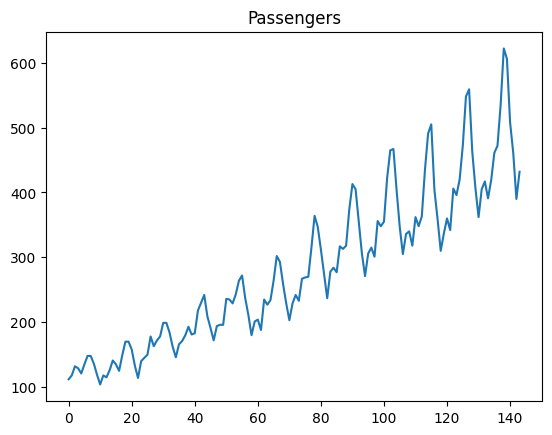

In [17]:
plt.plot(df['Passengers'])
plt.title('Passengers')
plt.show()

In [18]:
ds = FunctionDataset(df['Passengers'], lookback=4, split_ratio=0.8)

train_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 144, sequence length 4, total sequences 140, split ratio 0.8, train 112, test 28


In [19]:
len(train_loader), len(test_loader)

(14, 4)

In [20]:
# model z zajec
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 140 batches


[  10,   13] train RMSE: 252.737, test RMSE: 453.011
[  20,   13] train RMSE: 246.314, test RMSE: 446.241
[  30,   13] train RMSE: 240.841, test RMSE: 440.474
[  40,   13] train RMSE: 235.902, test RMSE: 435.256
[  50,   13] train RMSE: 231.178, test RMSE: 430.251
[  60,   13] train RMSE: 226.579, test RMSE: 425.362
[  70,   13] train RMSE: 222.063, test RMSE: 420.545
[  80,   13] train RMSE: 217.611, test RMSE: 415.78
[  90,   13] train RMSE: 213.211, test RMSE: 411.052
[ 100,   13] train RMSE: 208.855, test RMSE: 406.354
[ 110,   13] train RMSE: 204.539, test RMSE: 401.678
[ 120,   13] train RMSE: 200.26, test RMSE: 397.022
[ 130,   13] train RMSE: 196.017, test RMSE: 392.381
[ 140,   13] train RMSE: 191.808, test RMSE: 387.754
[ 150,   13] train RMSE: 187.634, test RMSE: 383.139
[ 160,   13] train RMSE: 183.496, test RMSE: 378.535
[ 170,   13] train RMSE: 179.393, test RMSE: 373.94
[ 180,   13] train RMSE: 175.204, test RMSE: 369.214
[ 190,   13] train RMSE: 170.806, test RMSE: 364.

In [21]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

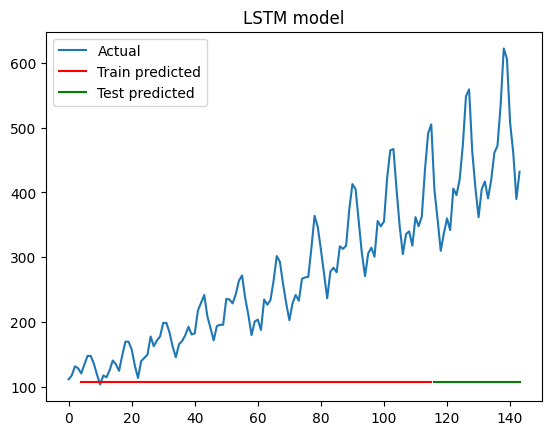

In [22]:
plot_model_results('LSTM model', df['Passengers'], train_preds_lstm, test_preds_lstm)

In [23]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 140 batches
[  10,   13] train RMSE: 250.301, test RMSE: 450.471
[  20,   13] train RMSE: 242.693, test RMSE: 442.387
[  30,   13] train RMSE: 236.25, test RMSE: 435.57
[  40,   13] train RMSE: 230.184, test RMSE: 429.126
[  50,   13] train RMSE: 224.034, test RMSE: 422.565
[  60,   13] train RMSE: 218.03, test RMSE: 416.132
[  70,   13] train RMSE: 212.184, test RMSE: 409.837
[  80,   13] train RMSE: 206.433, test RMSE: 403.612
[  90,   13] train RMSE: 200.757, test RMSE: 397.433
[ 100,   13] train RMSE: 194.387, test RMSE: 390.453
[ 110,   13] train RMSE: 188.351, test RMSE: 383.787
[ 120,   13] train RMSE: 182.072, test RMSE: 376.793
[ 130,   13] train RMSE: 176.123, test RMSE: 370.102
[ 140,   13] train RMSE: 170.332, test RMSE: 363.519
[ 150,   13] train RMSE: 164.658, test RMSE: 356.994
[ 160,   13] train RMSE: 159.091, test RMSE: 350.506
[ 170,   13] train RMSE: 153.544, test RMSE: 343.966
[ 180,   13] train RMSE: 147.342, test RMSE: 336.472
[ 190,   13] train RMSE: 

In [24]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

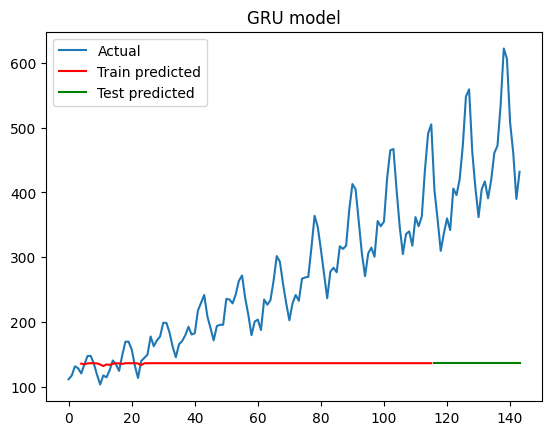

In [25]:
plot_model_results('GRU model', df['Passengers'], train_preds_gru, test_preds_gru)

In [26]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 140 batches


[  10,   13] train RMSE: 248.849, test RMSE: 448.882
[  20,   13] train RMSE: 241.72, test RMSE: 441.361
[  30,   13] train RMSE: 234.853, test RMSE: 434.089
[  40,   13] train RMSE: 228.107, test RMSE: 426.914
[  50,   13] train RMSE: 221.442, test RMSE: 419.792
[  60,   13] train RMSE: 214.843, test RMSE: 412.705
[  70,   13] train RMSE: 208.305, test RMSE: 405.642
[  80,   13] train RMSE: 201.825, test RMSE: 398.599
[  90,   13] train RMSE: 195.405, test RMSE: 391.572
[ 100,   13] train RMSE: 189.047, test RMSE: 384.559
[ 110,   13] train RMSE: 182.756, test RMSE: 377.558
[ 120,   13] train RMSE: 176.536, test RMSE: 370.568
[ 130,   13] train RMSE: 170.394, test RMSE: 363.59
[ 140,   13] train RMSE: 164.337, test RMSE: 356.622
[ 150,   13] train RMSE: 158.375, test RMSE: 349.665
[ 160,   13] train RMSE: 152.517, test RMSE: 342.718
[ 170,   13] train RMSE: 146.776, test RMSE: 335.781
[ 180,   13] train RMSE: 141.279, test RMSE: 328.998
[ 190,   13] train RMSE: 137.141, test RMSE: 323

In [27]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

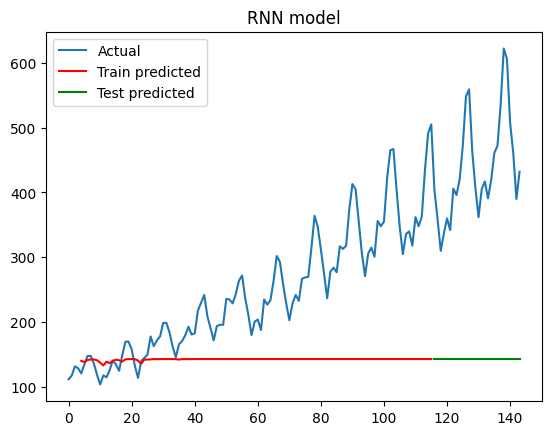

In [28]:
plot_model_results('RNN model', df['Passengers'], train_preds_rnn, test_preds_rnn)

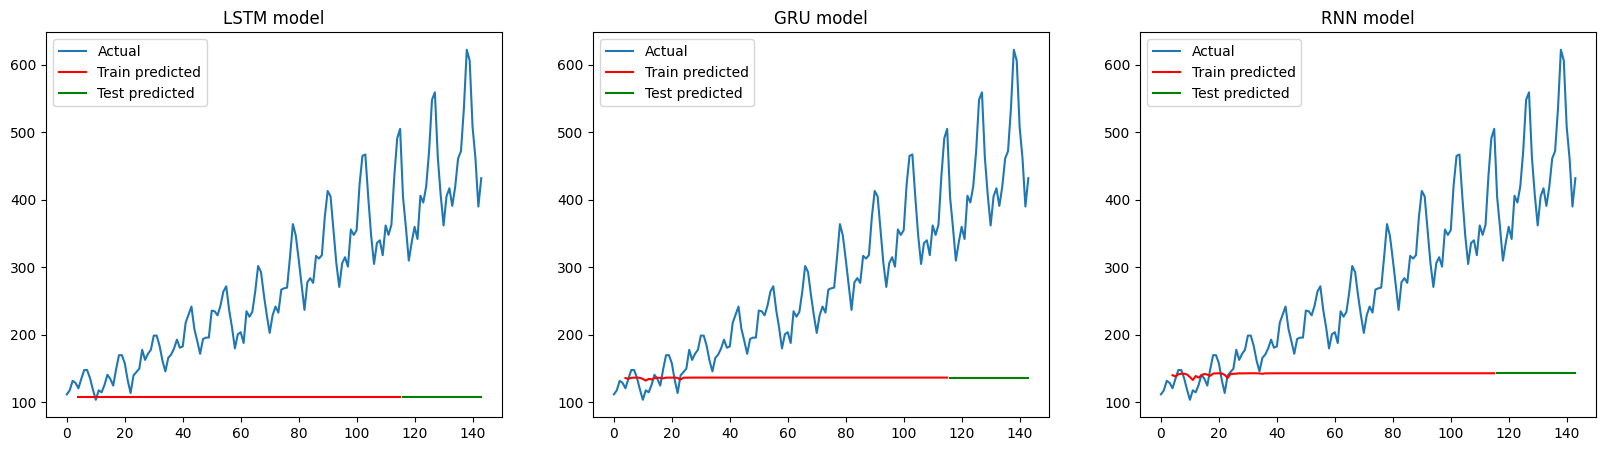

In [29]:
plot_all_results(lookback=4, train_preds_lstm=train_preds_lstm, test_preds_lstm=test_preds_lstm, train_preds_gru=train_preds_gru, test_preds_gru=test_preds_gru, train_preds_rnn=train_preds_rnn, test_preds_rnn=test_preds_rnn)


### Zad 2

In [30]:
import yfinance as yf
import seaborn as sns
from datetime import date
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [31]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

##### AAPL

In [32]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [33]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800


In [34]:
def data_plot(df, title):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.show()

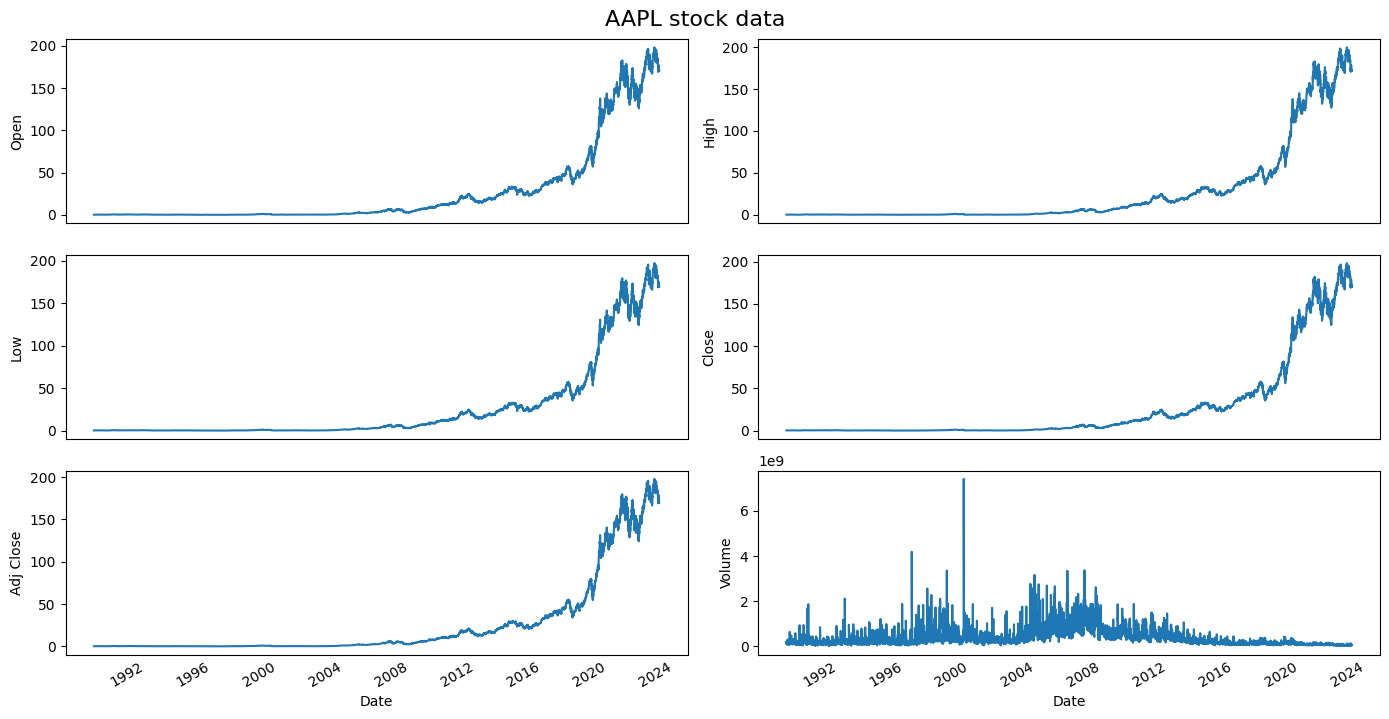

In [35]:
data_plot(df, 'AAPL stock data')

In [36]:
batch_size = 1024
lookback = 50

In [37]:
df['Open'].values.shape

(8627,)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))


In [39]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8627, sequence length 50, total sequences 8577, split ratio 0.8, train 6861, test 1716


In [40]:
len(train_loader), len(test_loader)

(7, 2)

In [41]:
# get the first batch

X, y = next(iter(train_loader))

X.shape, y.shape

(torch.Size([1024, 50, 1]), torch.Size([1024, 50, 1]))

In [42]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 70 batches


[  10,    6] train RMSE: 0.0479197, test RMSE: 0.554187
[  20,    6] train RMSE: 0.0308842, test RMSE: 0.406824
[  30,    6] train RMSE: 0.0150246, test RMSE: 0.232374
[  40,    6] train RMSE: 0.0138679, test RMSE: 0.224681
[  50,    6] train RMSE: 0.0129875, test RMSE: 0.211922
[  60,    6] train RMSE: 0.0122052, test RMSE: 0.198535
[  70,    6] train RMSE: 0.0115051, test RMSE: 0.185249
[  80,    6] train RMSE: 0.0108728, test RMSE: 0.172295
[  90,    6] train RMSE: 0.0102987, test RMSE: 0.159897
[ 100,    6] train RMSE: 0.00977762, test RMSE: 0.148402
[ 110,    6] train RMSE: 0.00930927, test RMSE: 0.138372
[ 120,    6] train RMSE: 0.00889867, test RMSE: 0.130378
[ 130,    6] train RMSE: 0.00854923, test RMSE: 0.1242
[ 140,    6] train RMSE: 0.00825029, test RMSE: 0.118511
[ 150,    6] train RMSE: 0.00798208, test RMSE: 0.112513
[ 160,    6] train RMSE: 0.00773355, test RMSE: 0.106618
[ 170,    6] train RMSE: 0.00761255, test RMSE: 0.099908
[ 180,    6] train RMSE: 0.00869747, test 

In [43]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

In [44]:
train_preds_lstm.shape,test_preds_lstm.shape, df['Open'].shape, 

((6861,), (1716,), (8627,))

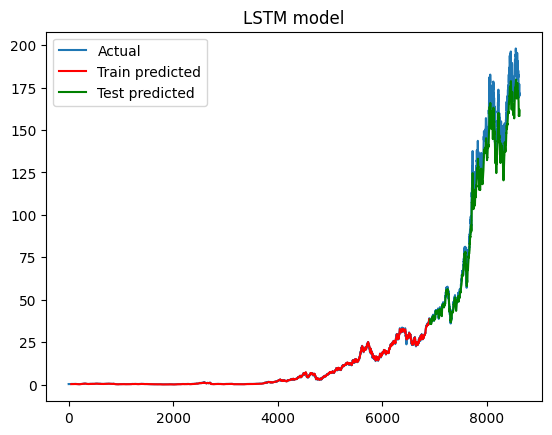

In [45]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [46]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 70 batches
[  10,    6] train RMSE: 0.0426933, test RMSE: 0.495382
[  20,    6] train RMSE: 0.0139382, test RMSE: 0.130578
[  30,    6] train RMSE: 0.0107823, test RMSE: 0.12819
[  40,    6] train RMSE: 0.00997067, test RMSE: 0.119628
[  50,    6] train RMSE: 0.00929818, test RMSE: 0.112024
[  60,    6] train RMSE: 0.00872124, test RMSE: 0.105365
[  70,    6] train RMSE: 0.00821778, test RMSE: 0.099445
[  80,    6] train RMSE: 0.0077716, test RMSE: 0.094101
[  90,    6] train RMSE: 0.00737044, test RMSE: 0.0892212
[ 100,    6] train RMSE: 0.00700478, test RMSE: 0.0847452
[ 110,    6] train RMSE: 0.00666475, test RMSE: 0.0808484
[ 120,    6] train RMSE: 0.00653106, test RMSE: 0.0787298
[ 130,    6] train RMSE: 0.013893, test RMSE: 0.0721868
[ 140,    6] train RMSE: 0.00577277, test RMSE: 0.0666387
[ 150,    6] train RMSE: 0.00549323, test RMSE: 0.065167
[ 160,    6] train RMSE: 0.0052921, test RMSE: 0.0626751
[ 170,    6] train RMSE: 0.00510135, test RMSE: 0.0603063
[ 180,  

In [47]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

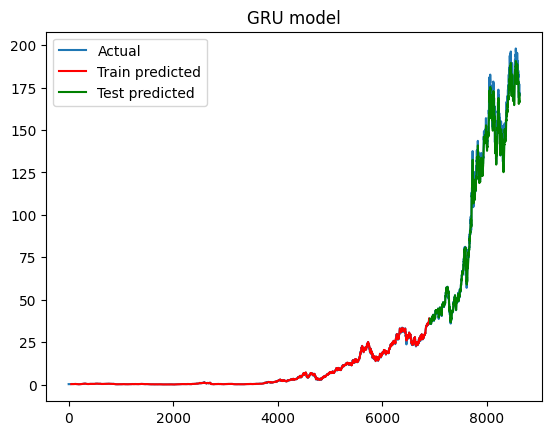

In [48]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [49]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 70 batches
[  10,    6] train RMSE: 0.0426971, test RMSE: 0.498789
[  20,    6] train RMSE: 0.0197615, test RMSE: 0.269199
[  30,    6] train RMSE: 0.0106856, test RMSE: 0.182955
[  40,    6] train RMSE: 0.00885934, test RMSE: 0.155492
[  50,    6] train RMSE: 0.00837065, test RMSE: 0.143235
[  60,    6] train RMSE: 0.00792047, test RMSE: 0.130733
[  70,    6] train RMSE: 0.00884498, test RMSE: 0.131399
[  80,    6] train RMSE: 0.00816378, test RMSE: 0.100383
[  90,    6] train RMSE: 0.00693228, test RMSE: 0.11144
[ 100,    6] train RMSE: 0.00685171, test RMSE: 0.0894828
[ 110,    6] train RMSE: 0.00766575, test RMSE: 0.0976704
[ 120,    6] train RMSE: 0.00751035, test RMSE: 0.0904965
[ 130,    6] train RMSE: 0.006916, test RMSE: 0.0772037
[ 140,    6] train RMSE: 0.00697055, test RMSE: 0.0917225
[ 150,    6] train RMSE: 0.00556934, test RMSE: 0.0674538
[ 160,    6] train RMSE: 0.00616666, test RMSE: 0.0758883
[ 170,    6] train RMSE: 0.00686815, test RMSE: 0.0765095
[ 180,

In [50]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

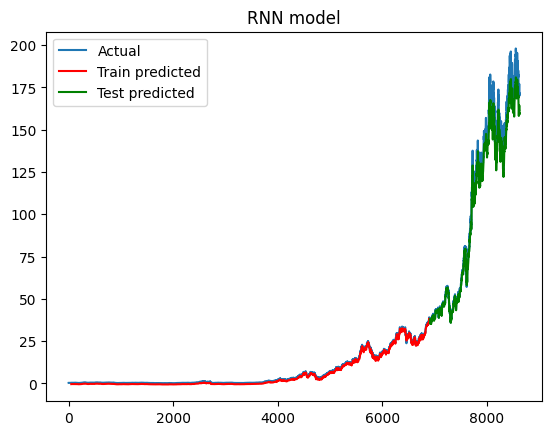

In [51]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

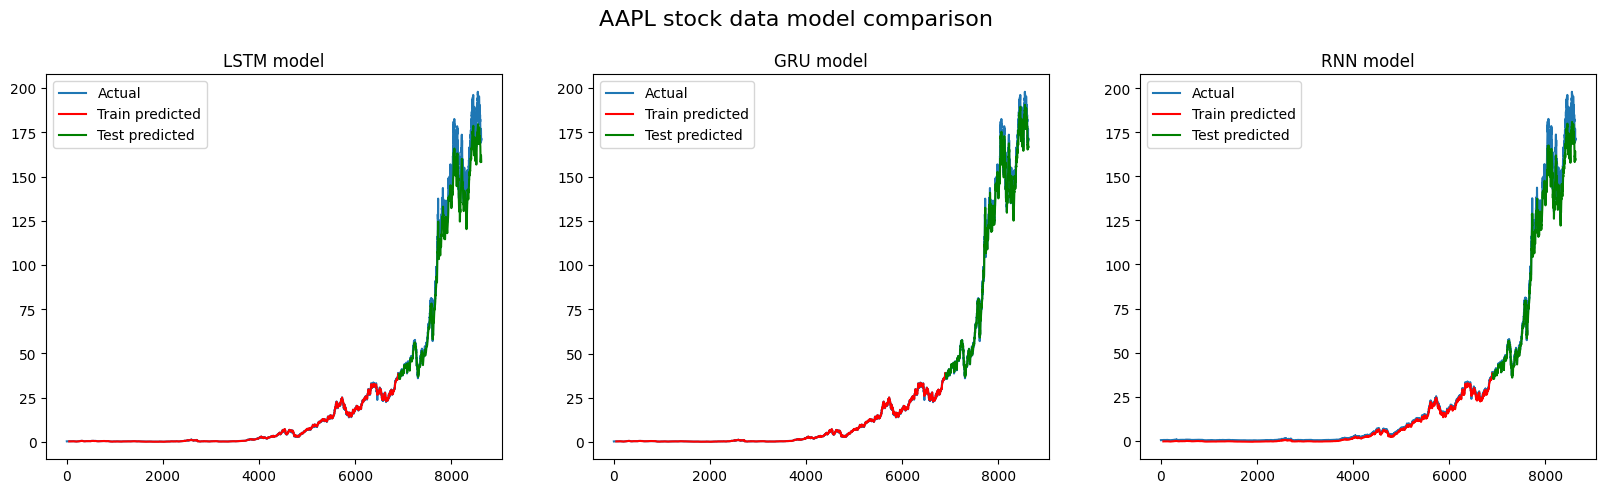

In [63]:
plot_all_results(
    title='AAPL stock data model comparison',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)